In [97]:
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

class state:
    def __init__(self,mode="dim"):
        if(mode == "dim"):
            self.tat = 5
            self.gfp = 75000
            self.ltr = 1
        else:
            self.tat = 25
            self.gfp = 300000
            self.ltr = 1
        self.nrna = 0
        self.crna = 0
        self.ptefb_a = 0
        self.ptefb_d = 0
        
    def toTuple(self):
        ret = (self.tat, self.gfp, self.ltr, self.nrna, self.crna, self.ptefb_a, self.ptefb_d)
        return(ret)
        
    def fromTuple(self, theTuple):
        self.tat = theTuple[0]
        self.gfp = theTuple[1]
        self.ltr = theTuple[2]
        self.nrna = theTuple[3]
        self.crna = theTuple[4]
        self.ptefb_a = theTuple[5]
        self.ptefb_d = theTuple[6]

class params:
    def __init__(self):
        self.k_basal = .000000001
        self.k_export = 0.00072
        self.k1_translate = 0.5
        self.k2_translate = 0.00132
        self.k_bind = 0.00015
        self.k_unbind = 0.017
        self.k_acetyl = 0.001
        self.k_deacetyl = 0.13
        self.k_transact = 0.1
        self.d_tat = 0.0000427777
        self.d_gfp = 0.00000301
        self.d_cyt = 0.000048
        self.d_nuc = 0.000048
        
    def toTuple(self):
        ret = (self.k_basal, self.k_export, self.k1_translate, self.k2_translate, self.k_bind, self.k_unbind, \
                self.k_acetyl, self.k_deacetyl, self.k_transact, self.d_tat, self.d_gfp, \
                self.d_cyt, self.d_nuc)
        return(ret)
        
    def fromTuple(self, theTuple):
        self.k_basal = float(theTuple[0])
        self.k_export = float(theTuple[1])
        self.k1_translate = float(theTuple[2])
        self.k2_translate = float(theTuple[3])
        self.k_bind = float(theTuple[4])
        self.k_unbind = float(theTuple[5])
        self.k_acetyl = float(theTuple[6])
        self.k_deacetyl = float(theTuple[7])
        self.k_transact = float(theTuple[8])
        self.d_tat = float(theTuple[9])
        self.d_gfp = float(theTuple[10])
        self.d_cyt = float(theTuple[11])
        self.d_nuc = float(theTuple[12])
        
#  LTR -- k_basal --> LTR + nRNA
#  nRNA -- k_export --> cRNA
#  cRNA -- k1_translate --> GFP + cRNA
#  cRNA -- k2_translate --> Tat + cRNA
#  Tat <-- k_bind/k_unbind --> pTEFb_d
#  LTR + pTEFb_d <-- k_acetyl/k_deacetyl --> pTEFb_a
#  pTEFb_a -- k_transact --> LTR + nRNA + Tat
#  GFP -- d_GFP --> 0
#  cRNA -- d_CYT --> 0
#  Tat -- d_Tat --> 0
#  nRNA -- d_NUC --> 0
    
def deriv(stateTuple, t, k_basal, k_export, k1_translate, k2_translate, k_bind, k_unbind, k_acetyl, k_deacetyl,\
            k_transact, d_tat, d_gfp, d_cyt, d_nuc):
    
    mystate = state()
    mystate.fromTuple(stateTuple)
    
    dnRNAdt = -1.0*(k_export * mystate.nrna + d_nuc * mystate.nrna) + \
                (k_basal * mystate.ltr + k_transact * mystate.ptefb_a)
    dcRNAdt = -1.0*(k1_translate * mystate.crna + k2_translate * mystate.crna + d_cyt * mystate.crna) + \
                (k_export * mystate.nrna + k1_translate * mystate.crna + k2_translate * mystate.crna)
    dGFPdt = -1.0*(d_gfp * mystate.gfp) + (k1_translate * mystate.crna)
    dTatdt = -1.0*(k_bind * mystate.tat + d_tat * mystate.tat) + \
                (k2_translate * mystate.crna + k_unbind * mystate.ptefb_d + k_transact * mystate.ptefb_a)
    dpTEFb_ddt = -1.0 * (k_acetyl * mystate.ptefb_d * mystate.ltr + k_unbind * mystate.ptefb_d) + \
                (k_bind * mystate.tat + k_deacetyl * mystate.ptefb_a)
    dpTEFb_adt = -1.0 * (k_transact * mystate.ptefb_a + k_deacetyl * mystate.ptefb_a) + \
                (k_acetyl * mystate.ltr * mystate.ptefb_d)
    dLTRdt = -1.0 * (k_basal * mystate.ltr + k_acetyl * mystate.ltr * mystate.ptefb_d) + \
                (k_basal * mystate.ltr + k_transact * mystate.ptefb_a)
    
    return(dnRNAdt, dcRNAdt, dGFPdt, dTatdt, dpTEFb_ddt, dpTEFb_adt, dLTRdt)

modelParams = params()
modelState = state(mode="dim")
odemax = 100.0
odemin = 0.0
buckets = 100.0
step = (odemax - odemin)/buckets
t = list(np.arange(odemin, odemax, step))

ret = odeint(deriv, modelState.toTuple(), t, args=modelParams.toTuple())
print("Done")

Done


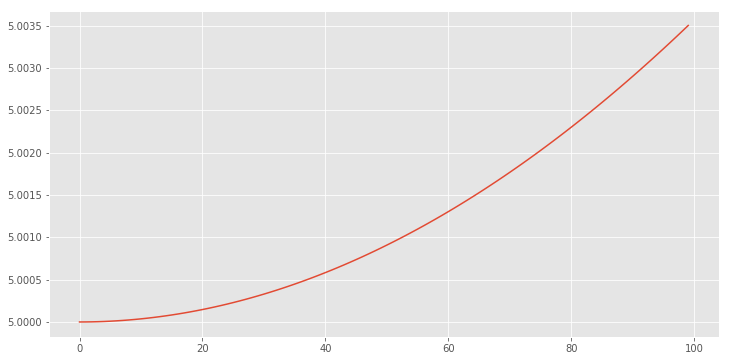

In [107]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(t, ret.T[0])
